# PCC Distance by Physical State v2

Run on local computer

Jones-Kellett et al. figs in this script:

Average coherence times in and out of eddies


NOTES

v2: Using output from `lat_diel_running_means_v3.ipynb`; not analyzing pos-neg preserved or raw abundances; added rank abundance plots



----

LJK 

Date created: 08/05/25

Last edited: 08/11/25

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import scipy.stats as spy
from scipy.stats import spearmanr
from config import * # directory file paths

In [2]:
fontsize = 18

plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=fontsize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=fontsize)  # fontsize of the figure title

## Load Datasets 

#### Set up metadata with eddy info and coherence time

In [3]:
metadata_df = pd.read_csv(data_dir + 'AVISO_metadata_15km_near_eddy.csv',index_col=0)
metadata_df = metadata_df.set_index('sample_id')[12:]
metadata_df.head()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc
sample_id,,,,,,,,
16,20211120,10:54,29.0000,236.5574,0,0,0,0
17,20211120,12:44,28.7390,236.1088,0,0,0,0
18,20211120,14:43,28.5030,235.7140,0,0,0,0
19,20211121,02:03,28.2847,235.3517,0,0,0,0
20,20211121,04:04,28.0397,234.9534,0,0,0,0


In [4]:
eddy_indicator = []
for i in range(len(metadata_df)):
    row = metadata_df.iloc[i]
    if (row['in_anti'] != 0) or (row['in_cyc'] != 0):
        eddy_indicator.append('Y')
    elif (row['near_anti'] != 0) or (row['near_cyc'] != 0):
        eddy_indicator.append('N')
    else:
        eddy_indicator.append('O')
metadata_df['eddy_indicator'] = eddy_indicator

Add coherence time to the DataFrame (mean of the 3 CMEMS runs)

In [5]:
coh_df = pd.read_csv(data_dir + 'coh_days_200day_backward_runtime_20min_timestep_6hr_output_freq_1000_gaussian_particles_0.025_std_dist_CMEMS_OSCAR_interim.csv',header=1,index_col='sample_id')
coh_df = coh_df.reset_index()
coh_df = coh_df.drop('0',axis='columns')[12:]
coh_df.head()

,sample_id,CMEMS_coherence_days_run0,CMEMS_coherence_days_run1,CMEMS_coherence_days_run2,OSCAR_coherence_days_run0,OSCAR_coherence_days_run1,OSCAR_coherence_days_run2
12,16,33.00,33.00,32.00,82.50,83.75,81.00
13,17,44.00,43.50,43.50,32.75,32.25,31.75
14,18,40.50,39.75,40.25,59.75,58.50,59.25
15,19,97.50,96.75,97.00,62.00,61.25,60.75
16,20,63.75,63.75,62.75,51.75,51.00,51.25


In [6]:
mean_coh = np.mean((coh_df.CMEMS_coherence_days_run0,coh_df.CMEMS_coherence_days_run1,coh_df.CMEMS_coherence_days_run2),axis=0)
metadata_df['mean_coh'] = mean_coh
metadata_df.head()

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,eddy_indicator,mean_coh
sample_id,,,,,,,,,,
16,20211120,10:54,29.0000,236.5574,0,0,0,0,O,32.666667
17,20211120,12:44,28.7390,236.1088,0,0,0,0,O,43.666667
18,20211120,14:43,28.5030,235.7140,0,0,0,0,O,40.166667
19,20211121,02:03,28.2847,235.3517,0,0,0,0,O,97.083333
20,20211121,04:04,28.0397,234.9534,0,0,0,0,O,63.416667


What is the average coherence times in and out of eddies?

In [7]:
print(np.mean(metadata_df[metadata_df['eddy_indicator'] == 'O']['mean_coh']))
print(np.median(metadata_df[metadata_df['eddy_indicator'] == 'O']['mean_coh']))

66.76282051282051
63.75


In [8]:
print(np.mean(metadata_df[metadata_df['eddy_indicator'] != 'O']['mean_coh']))
print(np.median(metadata_df[metadata_df['eddy_indicator'] != 'O']['mean_coh']))

65.02160493827161
55.916666666666664


In [9]:
#metadata_df.to_csv('../data/AVISO_metadata_15km_near_eddy_w_coh_time.csv')

#### Load filtered phytoplankton data (n=406): 
    - ASV raw abundance
    - ASV-level STA
    - Group-level (cyano + euk groups) STA

In [10]:
euk_ASV_no_low_freq_df = pd.read_csv(highcov_dir + 'euk_abs_ASV_abundance_IS_avg_station_avg_phytoplankon_filtered.csv',index_col=0)

In [11]:
# STA datasets
phyto_ASV_STA = pd.read_csv(highcov_dir + 'phyto_ASV_spatiotemporal_anoms_v3.csv',index_col=0)
cyan_ASV_STA = pd.read_csv(highcov_dir + 'cyan_phyto_ASV_spatiotemporal_anoms_v3.csv',index_col=0)
euk_ASV_STA = pd.read_csv(highcov_dir + 'euk_phyto_ASV_spatiotemporal_anoms_v3.csv',index_col=0)
phyto_group_STA = pd.read_csv(highcov_dir + 'phyto_ASV_spatiotemporal_group_anoms_v3.csv',index_col=0)

Drop the unknown group so that it doesn't affect the group results

In [12]:
phyto_group_STA = phyto_group_STA.drop('Unknown Eukaryote Chloroplast', axis=1)

## Rank Abundances

Seperate euks by rare and abundant. Sum of the data across all samples.

In [13]:
euk_sums = euk_ASV_no_low_freq_df.sum(axis=0).sort_values() # total abundance of every ASV, sorted from low to high
print(np.max(euk_sums))
print(np.min(euk_sums))
print(np.median(euk_sums))

63300.33369556867
65.05037984916557
741.7854053729919


In [14]:
abund_columns = euk_sums[euk_sums >= np.median(euk_sums)]
rare_columns = euk_sums[euk_sums < np.median(euk_sums)]

In [15]:
abund_euk_df = euk_ASV_no_low_freq_df[abund_columns.index]
np.shape(abund_euk_df)

(53, 166)

In [16]:
rare_euk_df = euk_ASV_no_low_freq_df[rare_columns.index]
np.shape(rare_euk_df)

(53, 166)

In [17]:
abund_euk_ASV_STA = euk_ASV_STA[abund_columns.index]
rare_euk_ASV_STA = euk_ASV_STA[rare_columns.index]

In [18]:
n_lines = 166
cmap = cm.get_cmap('jet')
color_codes = cmap(np.linspace(0, 1, n_lines))

In [19]:
abund_color_dict = {}
count = 0
for ASV in abund_columns.index:
    abund_color_dict[ASV] = list(color_codes[count])
    count += 1

In [20]:
rare_color_dict = {}
count = 0
for ASV in rare_columns.index:
    rare_color_dict[ASV] = list(color_codes[count])
    count += 1

In [21]:
outside_mixed_samples = list(metadata_df[(metadata_df.eddy_indicator == 'O') & (metadata_df.mean_coh < 90)].index)
outside_coh_samples = list(metadata_df[(metadata_df.eddy_indicator == 'O') & (metadata_df.mean_coh >= 90)].index)
eddy_samples = list(metadata_df[(metadata_df.eddy_indicator != 'O')].index)

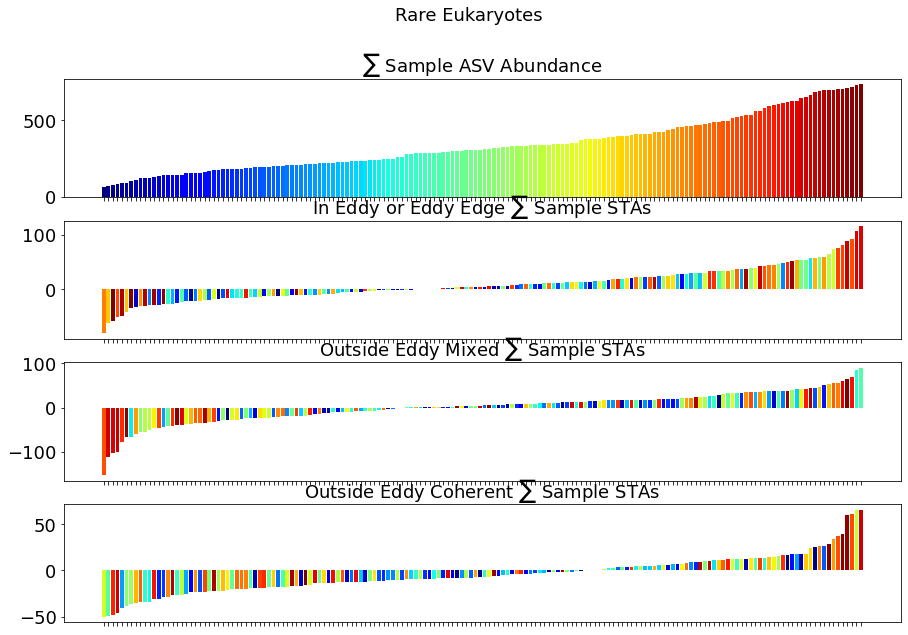

In [22]:
fig,ax = plt.subplots(4,1,figsize=(15,10))

## RAW DATA ##
ASVs = rare_euk_df.sum(axis=0).sort_values().index
colors = [rare_color_dict[a] for a in ASVs]
heights = rare_euk_df.sum(axis=0).sort_values().values

ax[0].bar(ASVs,heights,color=colors)
ax[0].set_title('$\sum$ Sample ASV Abundance')


## EDDY STA ##
ASVs = rare_euk_ASV_STA.loc[eddy_samples].sum(axis=0).sort_values().index
colors = [rare_color_dict[a] for a in ASVs]
heights = rare_euk_ASV_STA.loc[eddy_samples].sum(axis=0).sort_values().values

ax[1].bar(ASVs,heights,color=colors)
ax[1].set_title('In Eddy or Eddy Edge $\sum$ Sample STAs')


## OUTSIDE MIXED ##
ASVs = rare_euk_ASV_STA.loc[outside_mixed_samples].sum(axis=0).sort_values().index
colors = [rare_color_dict[a] for a in ASVs]
heights = rare_euk_ASV_STA.loc[outside_mixed_samples].sum(axis=0).sort_values().values

ax[2].bar(ASVs,heights,color=colors)
ax[2].set_title('Outside Eddy Mixed $\sum$ Sample STAs')


## OUTSIDE COH ##
ASVs = rare_euk_ASV_STA.loc[outside_coh_samples].sum(axis=0).sort_values().index
colors = [rare_color_dict[a] for a in ASVs]
heights = rare_euk_ASV_STA.loc[outside_coh_samples].sum(axis=0).sort_values().values

ax[3].bar(ASVs,heights,color=colors)
ax[3].set_title('Outside Eddy Coherent $\sum$ Sample STAs')


for a in ax:
    a.set_xticklabels([])
    
plt.suptitle('Rare Eukaryotes')

plt.show()

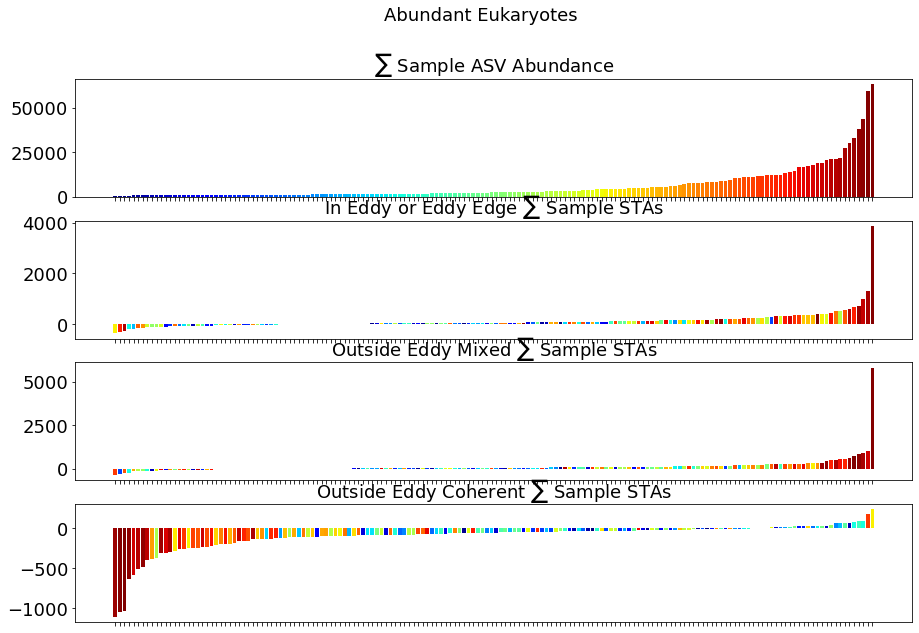

In [23]:
fig,ax = plt.subplots(4,1,figsize=(15,10))

## RAW DATA ##
ASVs = abund_euk_df.sum(axis=0).sort_values().index
colors = [abund_color_dict[a] for a in ASVs]
heights = abund_euk_df.sum(axis=0).sort_values().values

ax[0].bar(ASVs,heights,color=colors)
ax[0].set_title('$\sum$ Sample ASV Abundance')


## EDDY STA ##
ASVs = abund_euk_ASV_STA.loc[eddy_samples].sum(axis=0).sort_values().index
colors = [abund_color_dict[a] for a in ASVs]
heights = abund_euk_ASV_STA.loc[eddy_samples].sum(axis=0).sort_values().values

ax[1].bar(ASVs,heights,color=colors)
ax[1].set_title('In Eddy or Eddy Edge $\sum$ Sample STAs')


## OUTSIDE MIXED ##
ASVs = abund_euk_ASV_STA.loc[outside_mixed_samples].sum(axis=0).sort_values().index
colors = [abund_color_dict[a] for a in ASVs]
heights = abund_euk_ASV_STA.loc[outside_mixed_samples].sum(axis=0).sort_values().values

ax[2].bar(ASVs,heights,color=colors)
ax[2].set_title('Outside Eddy Mixed $\sum$ Sample STAs')


## OUTSIDE COH ##
ASVs = abund_euk_ASV_STA.loc[outside_coh_samples].sum(axis=0).sort_values().index
colors = [abund_color_dict[a] for a in ASVs]
heights = abund_euk_ASV_STA.loc[outside_coh_samples].sum(axis=0).sort_values().values

ax[3].bar(ASVs,heights,color=colors)
ax[3].set_title('Outside Eddy Coherent $\sum$ Sample STAs')


for a in ax:
    a.set_xticklabels([])

plt.suptitle('Abundant Eukaryotes')

plt.show()

## Dissimilarity

#### Calculate Spearman Rank Correlation distance between samples on STA:
    - All phyto STA
    - Cyan-only STA
    - Euk-only STA 
    - Group-level STA

In [24]:
neighbor_dis_setup = []
for i in range(len(metadata_df) - 1):
    sample1, sample2 = metadata_df.index[i], metadata_df.index[i+1] # names of samples
    lat1, lat2 = metadata_df.loc[sample1].latitude, metadata_df.loc[sample2].latitude
    mid_lat = lat1 - ((lat1 - lat2)/2)
    eddy1, eddy2 = metadata_df.loc[sample1].eddy_indicator, metadata_df.loc[sample2].eddy_indicator
    
    neighbor_dis_setup.append({'Sample Pair': f"{sample1} - {sample2}",
                                   'Latitude1': lat1,
                                   'Latitude2': lat2,
                                   'Middle Latitude': mid_lat,
                                  'Eddy Code': eddy1+eddy2})
    
neighbor_df = pd.DataFrame(neighbor_dis_setup)
neighbor_df.head()

,Sample Pair,Latitude1,Latitude2,Middle Latitude,Eddy Code
0,16 - 17,29.0000,28.7390,28.86950,OO
1,17 - 18,28.7390,28.5030,28.62100,OO
2,18 - 19,28.5030,28.2847,28.39385,OO
3,19 - 20,28.2847,28.0397,28.16220,OO
4,20 - 21,28.0397,27.8012,27.92045,OY


In [25]:
def spearman_distance(vec1, vec2):
    return 1 - np.abs(spearmanr(vec1, vec2)[0])

In [26]:
def calc_neighbor_diss(df):
    
    # Compute pairwise distances for neighboring samples
    neighbor_distances = []
    for i in range(len(df) - 1):
        a, b = df.iloc[i].values, df.iloc[i+1].values 
        neighbor_distances.append(spearman_distance(a, b))
        
    return neighbor_distances

In [27]:
cyan_color = '#3B945E'
euk_color = '#5F2A7F'
phyto_color = 'k'

In [28]:
def add_eddy_shading_to_neighbor_plot(ax,eddy_ypos,eddy_labels=True):
    eddy_type_dict = {'in_anti':['firebrick','x'],
                  'near_anti':['firebrick','//'],
                  'in_cyc':['mediumblue','x'],
                  'near_cyc':['mediumblue','//']}

    for eddy_type,values in eddy_type_dict.items():
        eddy_ids = np.unique(metadata_df.iloc[np.where(metadata_df[eddy_type] != 0)[0]][eddy_type])
        for ID in eddy_ids:
            inds = np.where([metadata_df[eddy_type] == ID])[1] - 0.5

            if (eddy_type == 'in_anti') or (eddy_type == 'in_cyc'):
                ax.fill_between([inds[0]-0.5,inds[-1]+0.5],ymin,y2=ymax, 
                                facecolor=values[0],alpha=0.1,linewidth=0)
            else:
                for i in np.arange(0,len(inds)):
                    ax.fill_between([inds[i]-0.5,inds[i]+0.5],ymin,y2=ymax,hatch=values[1], 
                                facecolor='none', edgecolor=values[0],alpha=0.5,linewidth=0)

    if eddy_labels:
        adjustment = 0.5
        ax.text(3.5-adjustment,eddy_ypos,'Shrutie')
        ax.text(8.75-adjustment,eddy_ypos,'Zinka')
        ax.text(20.75-adjustment,eddy_ypos,'Dean')
        ax.text(27.5-adjustment,eddy_ypos,'Josh')
        ax.text(32.5-adjustment,eddy_ypos,'Sharon')
        ax.text(38.25-adjustment,eddy_ypos,'Cathy')
        ax.text(46-adjustment,eddy_ypos,'Koko')

In [29]:
def distance_mat(df):
        
    site_names = df.index
    similarity_mat = np.full((len(site_names), len(site_names)), np.nan) # Initialize the similarity matrix

    # Compute the similarity matrix
    for i in range(len(site_names)):
        for j in range(i, len(site_names)): 
            similarity_mat[i, j] = spearman_distance(df.loc[site_names[i]], df.loc[site_names[j]])
                
    return similarity_mat

In [30]:
neighbor_df['all_phyto_STA_spearman'] = calc_neighbor_diss(phyto_ASV_STA)
neighbor_df['cyan_phyto_STA_spearman'] = calc_neighbor_diss(cyan_ASV_STA)
neighbor_df['euk_phyto_STA_spearman'] = calc_neighbor_diss(euk_ASV_STA)
neighbor_df['phyto_groups_STA_spearman'] = calc_neighbor_diss(phyto_group_STA)
neighbor_df

,Sample Pair,Latitude1,Latitude2,Middle Latitude,Eddy Code,all_phyto_STA_spearman,cyan_phyto_STA_spearman,euk_phyto_STA_spearman,phyto_groups_STA_spearman
0,16 - 17,29.0000,28.7390,28.86950,OO,0.885437,0.713158,0.935725,0.054545
1,17 - 18,28.7390,28.5030,28.62100,OO,0.994073,0.473395,0.854506,0.481818
2,18 - 19,28.5030,28.2847,28.39385,OO,0.794586,0.938201,0.706073,0.118182
3,19 - 20,28.2847,28.0397,28.16220,OO,0.865862,0.805035,0.882857,0.900000
4,20 - 21,28.0397,27.8012,27.92045,OY,0.968861,0.742214,0.965531,0.809091
5,21 - 22,27.8012,27.5684,27.68480,YN,0.775990,0.330455,0.922028,0.981818
6,22 - 23,27.5684,27.3373,27.45285,NO,0.624729,0.403643,0.687036,0.509091
7,23 - 24,27.3373,27.0992,27.21825,OO,0.717889,0.734424,0.716775,0.809091
8,24 - 25,27.0992,26.8725,26.98585,OY,0.900533,0.806931,0.828698,0.490909
9,25 - 26,26.8725,26.6520,26.76225,YY,0.834940,0.456483,0.964681,0.745455


#### Panel (a) of supp fig

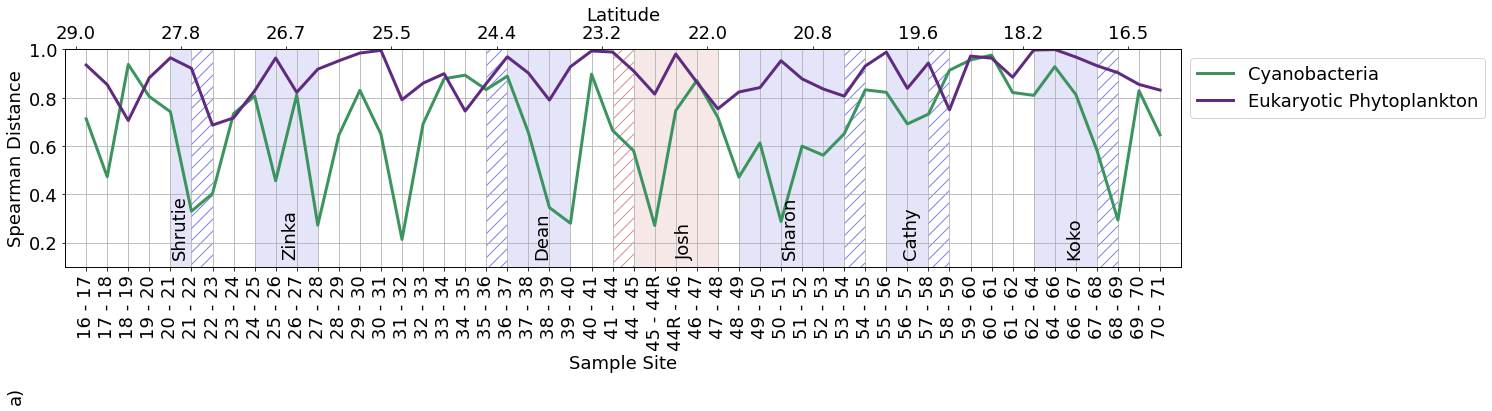

In [31]:
fig,ax = plt.subplots(1,1,figsize=(20,4))

linewidth=3
ax.plot(neighbor_df['cyan_phyto_STA_spearman'],c=cyan_color,linewidth=linewidth,label='Cyanobacteria')
ax.plot(neighbor_df['euk_phyto_STA_spearman'],c=euk_color,linewidth=linewidth,label='Eukaryotic Phytoplankton')

ax.set_xticks(np.arange(0,len(neighbor_df)))
ax.set_xticklabels(neighbor_df['Sample Pair'],rotation=90)
ax.grid(True)
ax.legend(bbox_to_anchor=(1,1))

ymin,ymax = 0.1,1
ax.set_ylim([ymin,ymax])
ax.set_xlim([-1,len(neighbor_df)])

################# EDDY SHADING #################

add_eddy_shading_to_neighbor_plot(ax,0.025,False)

adjustment = -0.5
eddy_ypos = 0.15
ax.text(3.5-adjustment,eddy_ypos,'Shrutie',rotation=90)
ax.text(8.75-adjustment,eddy_ypos,'Zinka',rotation=90)
ax.text(20.75-adjustment,eddy_ypos,'Dean',rotation=90)
ax.text(27.5-adjustment,eddy_ypos,'Josh',rotation=90)
ax.text(32.5-adjustment,eddy_ypos,'Sharon',rotation=90)
ax.text(38.25-adjustment,eddy_ypos,'Cathy',rotation=90)
ax.text(46-adjustment,eddy_ypos,'Koko',rotation=90)

###################################################

# Add a latitude axis
ax0b = ax.twiny()
ax0b.set_xlim(ax.get_xlim())
ax0b.set_xticks(np.arange(0-0.5,53-0.5,5)) # need to adjust by 0.5 for neighbor centering
ax0b.set_xticklabels([str(round(i,1)) for i in metadata_df.latitude][::5])
ax0b.set_xlabel('Latitude')
ax.set_xlabel('Sample Site')
ax.set_ylabel('Spearman Distance')

ax.text(-3.75,-0.45,'a)',rotation=90)
#plt.savefig(euk_paper_dir + 'figs/supp/prelim/neighbor_spearman_v3.pdf',dpi=350,bbox_inches='tight',format='pdf')
plt.show()

In [33]:
#neighbor_df.to_csv(highcov_dir + 'neighbor_metrics_v2.csv',index=False)

## Hypothesis Testing

### Hypothesis: Coherent, outside-eddy samples are distinct from neighbors

Subset to only outside-eddy samples

In [34]:
outside_eddy = metadata_df[metadata_df.eddy_indicator == 'O']
print(len(outside_eddy))
print(np.quantile(outside_eddy.mean_coh,0.75))

26
90.10416666666667


In [35]:
outside_eddy_most_coh = outside_eddy[outside_eddy.mean_coh.ge(90)]
outside_eddy_most_coh

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,eddy_indicator,mean_coh
sample_id,,,,,,,,,,
19,20211121,02:03,28.2847,235.3517,0,0,0,0,O,97.083333
30,20211122,04:03,25.7446,231.1433,0,0,0,0,O,119.583333
35,20211122,13:13,24.6388,229.3400,0,0,0,0,O,90.750000
41,20211123,01:25,23.1732,226.9761,0,0,0,0,O,96.000000
60,20211126,06:00,18.7320,220.6000,0,0,0,0,O,131.583333
69,20211127,01:02,16.4513,219.9996,0,0,0,0,O,150.500000
70,20211127,03:00,16.0360,219.9977,0,0,0,0,O,118.750000


In [36]:
outside_eddy_less_coh = outside_eddy[~outside_eddy.mean_coh.ge(90)] # ge indicates greater than or equal to
outside_eddy_less_coh

,date,time_UTC,latitude,longitude,in_anti,near_anti,in_cyc,near_cyc,eddy_indicator,mean_coh
sample_id,,,,,,,,,,
16,20211120,10:54,29.0000,236.5574,0,0,0,0,O,32.666667
17,20211120,12:44,28.7390,236.1088,0,0,0,0,O,43.666667
18,20211120,14:43,28.5030,235.7140,0,0,0,0,O,40.166667
20,20211121,04:04,28.0397,234.9534,0,0,0,0,O,63.416667
23,20211121,09:53,27.3373,233.7767,0,0,0,0,O,45.583333
24,20211121,11:53,27.0992,233.3740,0,0,0,0,O,12.833333
28,20211122,00:41,26.1498,231.8127,0,0,0,0,O,61.166667
29,20211122,02:10,25.9711,231.5141,0,0,0,0,O,39.916667
31,20211122,05:58,25.5160,230.7660,0,0,0,0,O,78.083333


In [37]:
coh_to_not_pairs = []
for pair in list(neighbor_df[neighbor_df['Eddy Code'] == 'OO']['Sample Pair']):
    s = pair.split(' - ')
    if (((s[0] in outside_eddy_most_coh.index) and (s[1] not in outside_eddy_most_coh.index)) 
        or ((s[1] in outside_eddy_most_coh.index) and (s[0] not in outside_eddy_most_coh.index))):
        coh_to_not_pairs.append(pair)
coh_to_not_pairs

['18 - 19',
 '19 - 20',
 '29 - 30',
 '30 - 31',
 '34 - 35',
 '40 - 41',
 '59 - 60',
 '60 - 61',
 '70 - 71']

In [38]:
not_coh_to_not_pairs = []
for pair in list(neighbor_df[neighbor_df['Eddy Code'] == 'OO']['Sample Pair']):
    s = pair.split(' - ')
    if ((s[0] in outside_eddy_less_coh.index) and (s[1] in outside_eddy_less_coh.index)):
        not_coh_to_not_pairs.append(pair)
not_coh_to_not_pairs

['16 - 17',
 '17 - 18',
 '23 - 24',
 '28 - 29',
 '31 - 32',
 '32 - 33',
 '33 - 34',
 '61 - 62']

In [39]:
def filled_boxplot(ax, bp_data, labels, colors):
    boxplot = ax.boxplot(bp_data,patch_artist=True,labels=labels, widths=0.3,zorder=10)
    for patch, color in zip(boxplot['boxes'], colors):
        patch.set_facecolor(color)
    for median in boxplot['medians']:
        median.set_color('black')
    ax.grid(True,axis='y',zorder=0)
    bp_means = [np.mean(b) for b in bp_data]
    ax.scatter(np.arange(1,len(bp_data)+1),bp_means,zorder=12,c='white',edgecolor='k',s=200,marker='*',label='Mean')

#### Spearman Distance on STA

In [40]:
box_coh_mix = neighbor_df[neighbor_df['Sample Pair'].isin(coh_to_not_pairs)] # outside eddy: coherent to not coherent neighbors
box_mix_mix = neighbor_df[neighbor_df['Sample Pair'].isin(not_coh_to_not_pairs)] # outside eddy: not coherent to not coherent neighbors

In [41]:
box_coh_mix 

,Sample Pair,Latitude1,Latitude2,Middle Latitude,Eddy Code,all_phyto_STA_spearman,cyan_phyto_STA_spearman,euk_phyto_STA_spearman,phyto_groups_STA_spearman
2,18 - 19,28.5030,28.2847,28.39385,OO,0.794586,0.938201,0.706073,0.118182
3,19 - 20,28.2847,28.0397,28.16220,OO,0.865862,0.805035,0.882857,0.900000
13,29 - 30,25.9711,25.7446,25.85785,OO,0.924071,0.830685,0.985274,0.900000
14,30 - 31,25.7446,25.5160,25.63030,OO,0.893451,0.649330,0.996410,0.627273
18,34 - 35,24.8370,24.6388,24.73790,OO,0.767254,0.893506,0.745044,0.581818
24,40 - 41,23.4384,23.1732,23.30580,OO,0.967348,0.898038,0.993866,0.781818
42,59 - 60,19.0250,18.7320,18.87850,OO,0.988239,0.956831,0.972455,0.427273
43,60 - 61,18.7320,18.4460,18.58900,OO,0.971579,0.976646,0.964257,0.718182
51,70 - 71,16.0360,15.6172,15.82660,OO,0.776754,0.646842,0.831793,0.200000


In [42]:
box_mix_mix

,Sample Pair,Latitude1,Latitude2,Middle Latitude,Eddy Code,all_phyto_STA_spearman,cyan_phyto_STA_spearman,euk_phyto_STA_spearman,phyto_groups_STA_spearman
0,16 - 17,29.0000,28.7390,28.86950,OO,0.885437,0.713158,0.935725,0.054545
1,17 - 18,28.7390,28.5030,28.62100,OO,0.994073,0.473395,0.854506,0.481818
7,23 - 24,27.3373,27.0992,27.21825,OO,0.717889,0.734424,0.716775,0.809091
12,28 - 29,26.1498,25.9711,26.06045,OO,0.930741,0.645687,0.953136,0.909091
15,31 - 32,25.5160,25.2820,25.39900,OO,0.644955,0.213906,0.791916,0.581818
16,32 - 33,25.2820,25.0580,25.17000,OO,0.964907,0.691744,0.860500,0.609091
17,33 - 34,25.0580,24.8370,24.94750,OO,0.944591,0.879052,0.899835,0.972727
44,61 - 62,18.4460,18.1839,18.31495,OO,0.879092,0.821947,0.885223,1.000000


In [43]:
def jitter_plot(ax, bp_data, color):
    for i, d in enumerate(bp_data):
        x = np.random.normal(i + 1, 0.02, size=len(d)) # Jitter x-coords
        ax.scatter(x, d, alpha=0.4, edgecolors='k', c=color,zorder=10) # Plot jittered points

#### Panel (c) of supp fig

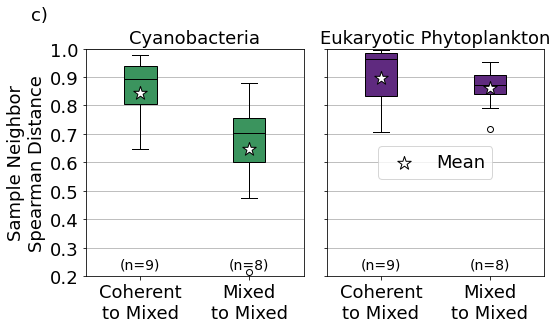

In [44]:
fig,ax = plt.subplots(1,2,figsize=(8,5))

cyan_data = [box_coh_mix['cyan_phyto_STA_spearman'],box_mix_mix['cyan_phyto_STA_spearman']]
euk_data = [box_coh_mix['euk_phyto_STA_spearman'],box_mix_mix['euk_phyto_STA_spearman']]

filled_boxplot(ax[0],cyan_data,['Coherent\nto Mixed','Mixed\nto Mixed'],[cyan_color,cyan_color])
ax[0].set_title('Cyanobacteria')

filled_boxplot(ax[1],euk_data,['Coherent\nto Mixed','Mixed\nto Mixed'],[euk_color,euk_color])
ax[1].set_title('Eukaryotic Phytoplankton')

ax[0].set_ylabel('Sample Neighbor\nSpearman Distance')

for i in np.arange(0,2):
    ax[0].text(i+1,0.225,'(n=%s)'%(len([box_coh_mix,box_mix_mix][i]['cyan_phyto_STA_spearman'])),ha='center',fontsize=14)
    ax[1].text(i+1,0.225,'(n=%s)'%(len([box_coh_mix,box_mix_mix][i]['euk_phyto_STA_spearman'])),ha='center',fontsize=14)

ax[0].text(0,1.1,'c)')

for a in ax:
    a.set_yticks(np.arange(0.2,1.2,0.1))
    a.set_ylim([0.2,1])

ax[1].legend(loc='center')
ax[1].set_yticklabels([])

plt.tight_layout()

#plt.savefig(euk_paper_dir + 'figs/supp/prelim/neighbor_spearman_outside_v3.pdf',dpi=350,bbox_inches='tight',format='pdf')

### Hypothesis: In-eddy & near eddy samples harbor a distinct community

In [45]:
outside_eddy = metadata_df[metadata_df.eddy_indicator == 'O']
in_eddy = metadata_df[metadata_df.eddy_indicator == 'Y']
near_eddy = metadata_df[metadata_df.eddy_indicator == 'N']

print(len(outside_eddy))
print(len(in_eddy))
print(len(near_eddy))

26
21
6


In [46]:
eddy_to_outside_pairs = []
for pair in list(neighbor_df['Sample Pair']):
    s = pair.split(' - ')
    if (((s[0] in in_eddy.index) and (s[1] in outside_eddy.index)) 
        or ((s[1] in in_eddy.index) and (s[0] in outside_eddy.index))):
        eddy_to_outside_pairs.append(pair)
eddy_to_outside_pairs

['20 - 21',
 '24 - 25',
 '27 - 28',
 '39 - 40',
 '47 - 48',
 '48 - 49',
 '55 - 56',
 '62 - 64']

In [47]:
eddy_to_eddy_pairs = []
for pair in list(neighbor_df['Sample Pair']):
    s = pair.split(' - ')
    if ((s[0] in in_eddy.index) and (s[1] in in_eddy.index)):
        eddy_to_eddy_pairs.append(pair)
eddy_to_eddy_pairs

['25 - 26',
 '26 - 27',
 '37 - 38',
 '38 - 39',
 '45 - 44R',
 '44R - 46',
 '46 - 47',
 '49 - 50',
 '50 - 51',
 '51 - 52',
 '52 - 53',
 '56 - 57',
 '64 - 66',
 '66 - 67']

In [48]:
outside_to_outside_pairs = []
for pair in list(neighbor_df['Sample Pair']):
    s = pair.split(' - ')
    if ((s[0] in outside_eddy.index) and (s[1] in outside_eddy.index)):
        outside_to_outside_pairs.append(pair)
outside_to_outside_pairs

['16 - 17',
 '17 - 18',
 '18 - 19',
 '19 - 20',
 '23 - 24',
 '28 - 29',
 '29 - 30',
 '30 - 31',
 '31 - 32',
 '32 - 33',
 '33 - 34',
 '34 - 35',
 '40 - 41',
 '59 - 60',
 '60 - 61',
 '61 - 62',
 '69 - 70',
 '70 - 71']

In [49]:
eddy_to_near_eddy_pairs = []
for pair in list(neighbor_df['Sample Pair']):
    s = pair.split(' - ')
    if (((s[0] in in_eddy.index) and (s[1] in near_eddy.index)) 
        or ((s[1] in in_eddy.index) and (s[0] in near_eddy.index))):
        eddy_to_near_eddy_pairs.append(pair)
eddy_to_near_eddy_pairs

['21 - 22', '36 - 37', '44 - 45', '53 - 54', '57 - 58', '67 - 68']

In [50]:
outside_to_near_eddy_pairs = []
for pair in list(neighbor_df['Sample Pair']):
    s = pair.split(' - ')
    if (((s[0] in outside_eddy.index) and (s[1] in near_eddy.index)) 
        or ((s[1] in outside_eddy.index) and (s[0] in near_eddy.index))):
        outside_to_near_eddy_pairs.append(pair)
outside_to_near_eddy_pairs

['22 - 23', '35 - 36', '41 - 44', '54 - 55', '58 - 59', '68 - 69']

In [51]:
box1 = neighbor_df[neighbor_df['Sample Pair'].isin(eddy_to_eddy_pairs)]
box2 = neighbor_df[neighbor_df['Sample Pair'].isin(eddy_to_near_eddy_pairs)]
box3 = neighbor_df[neighbor_df['Sample Pair'].isin(eddy_to_outside_pairs)] 
box4 = neighbor_df[neighbor_df['Sample Pair'].isin(outside_to_near_eddy_pairs)] 
box5 = neighbor_df[neighbor_df['Sample Pair'].isin(outside_to_outside_pairs)]
box5

,Sample Pair,Latitude1,Latitude2,Middle Latitude,Eddy Code,all_phyto_STA_spearman,cyan_phyto_STA_spearman,euk_phyto_STA_spearman,phyto_groups_STA_spearman
0,16 - 17,29.0000,28.7390,28.86950,OO,0.885437,0.713158,0.935725,0.054545
1,17 - 18,28.7390,28.5030,28.62100,OO,0.994073,0.473395,0.854506,0.481818
2,18 - 19,28.5030,28.2847,28.39385,OO,0.794586,0.938201,0.706073,0.118182
3,19 - 20,28.2847,28.0397,28.16220,OO,0.865862,0.805035,0.882857,0.900000
7,23 - 24,27.3373,27.0992,27.21825,OO,0.717889,0.734424,0.716775,0.809091
12,28 - 29,26.1498,25.9711,26.06045,OO,0.930741,0.645687,0.953136,0.909091
13,29 - 30,25.9711,25.7446,25.85785,OO,0.924071,0.830685,0.985274,0.900000
14,30 - 31,25.7446,25.5160,25.63030,OO,0.893451,0.649330,0.996410,0.627273
15,31 - 32,25.5160,25.2820,25.39900,OO,0.644955,0.213906,0.791916,0.581818
16,32 - 33,25.2820,25.0580,25.17000,OO,0.964907,0.691744,0.860500,0.609091


#### Panel (b) of supp fig

Text(-0.75, 1.1, 'b)')

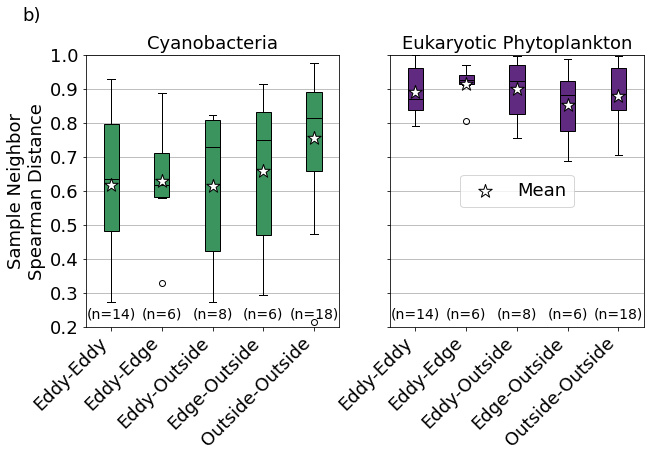

In [52]:
fig,ax = plt.subplots(1,2,figsize=(10,5))

boxes = [box1,box2,box3,box4,box5]

cyan_data = [box['cyan_phyto_STA_spearman'] for box in boxes]
euk_data = [box['euk_phyto_STA_spearman'] for box in boxes]

labels = ['Eddy-Eddy','Eddy-Edge','Eddy-Outside',
          'Edge-Outside','Outside-Outside']

for i in np.arange(0,len(boxes)):
    ax[0].text(i+1,0.225,'(n=%s)'%(len(boxes[i]['cyan_phyto_STA_spearman'])),ha='center',fontsize=14)
    ax[1].text(i+1,0.225,'(n=%s)'%(len(boxes[i]['euk_phyto_STA_spearman'])),ha='center',fontsize=14)

filled_boxplot(ax[0],cyan_data,labels,[cyan_color]*len(labels))
ax[0].set_title('Cyanobacteria')

filled_boxplot(ax[1],euk_data,labels,[euk_color]*len(labels))
ax[1].set_title('Eukaryotic Phytoplankton')
ax[0].set_ylabel('Sample Neighbor\nSpearman Distance')

for a in range(2):
    ax[a].set_yticks(np.arange(0.2,1.2,0.1))
    ax[a].set_xticklabels(labels, rotation=45, ha='right')
    ax[a].set_ylim([0.2,1])

ax[1].legend(loc='center')
ax[1].set_yticklabels([])
    
ax[0].text(-0.75,1.1,'b)')

#plt.savefig(euk_paper_dir + 'figs/supp/prelim/neighbor_spearman_eddies_v3.pdf',dpi=350,bbox_inches='tight',format='pdf')

### Hypothesis: Neighbor samples collected across FTLE peaks are dissimilar

In [53]:
FTLE_table = pd.read_csv(data_dir + 'gradients_FTLE/FTLE_bn_G4_samples_by_timescale.csv',index_col=0)
FTLE_table.head()

,14,21,28,35,42,49,56,63
29.000000,1.148689,0.780960,0.631279,0.525629,0.447674,0.390197,0.346628,0.311229
28.976273,1.140441,0.783595,0.628088,0.519865,0.442923,0.386186,0.341512,0.305753
28.952545,1.169941,0.780987,0.606036,0.488084,0.403060,0.332880,0.285232,0.258664
28.928818,1.192393,0.771671,0.577953,0.469494,0.390780,0.336553,0.293164,0.258026
28.905091,1.211708,0.813317,0.612931,0.507533,0.430558,0.375043,0.328745,0.290961


In [54]:
def distance_from_lat_lon(lat1,lon1,lat2,lon2):
    """
    Returns the distance in kilometers between two coordinate points. Accepts negative (-180 to 180) or positive coordinate systems
 (0 to 360). 

    lat1,lon1: coordinates for point 1
    lat2,lon2: coordinates for point 2
    """
    R = 6371 # Radius of the earth in km
    delta_lat,delta_lon = math.radians(lat2-lat1),math.radians(lon2-lon1)
    lat1_radians,lat2_radians = math.radians(lat1),math.radians(lat2)
    a = math.sin(delta_lat/2)*math.sin(delta_lat/2)+math.cos(lat1_radians)*math.cos(lat2_radians)*((math.sin(delta_lon/2))**2)
    dist = R*2*math.atan2(math.sqrt(a),math.sqrt(1-a)) # Distance in km
    return dist

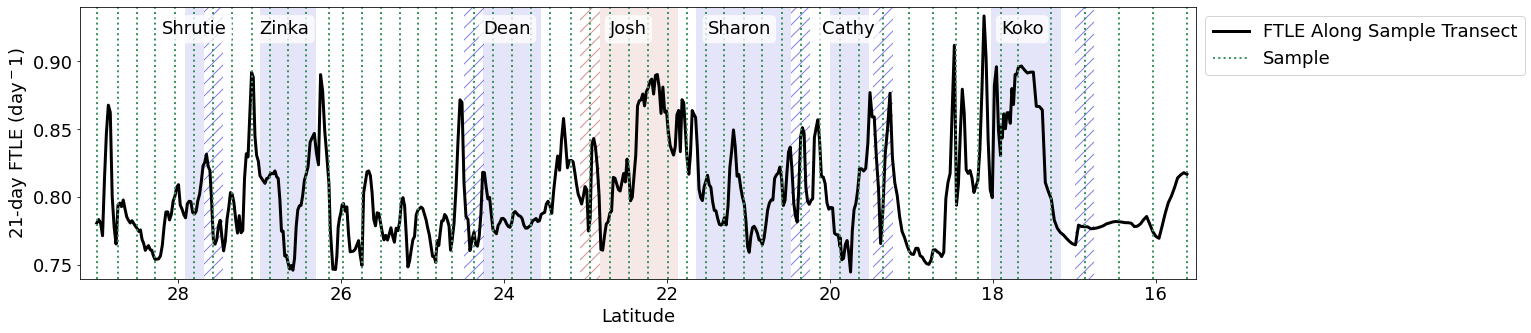

In [55]:
fig, ax = plt.subplots(1,1,figsize=(20,5))

FTLE_lats = FTLE_table.index
timescale = '21' # days

ax.plot(FTLE_lats,FTLE_table[timescale],c='k',linewidth=3,zorder=1,label='FTLE Along Sample Transect')

# Label where samples were collected
linewidth = 2
trigger = 0 
for sample in metadata_df.index:
    linestyle = ':'
    if trigger == 0:
        label = 'Sample'
        trigger = 1
    else:
        label = None
                    
    ax.axvline(metadata_df.loc[sample].latitude,linewidth=linewidth,linestyle=linestyle,color=cyan_color,label=label)
    
# Params
ymin,ymax = 0.74,0.94
ax.set_ylim([ymin,ymax])
ax.set_xlim([15.5,29.2])

ax.invert_xaxis() # switch to north to south
ax.legend(bbox_to_anchor=(1,1))
    
################# EDDY SHADING #################

eddy_type_dict = {'in_anti':['firebrick','x'],
                  'near_anti':['firebrick','//'],
                  'in_cyc':['mediumblue','x'],
                  'near_cyc':['mediumblue','//']}

for eddy_type,values in eddy_type_dict.items():
    eddy_ids = np.unique(metadata_df.iloc[np.where(metadata_df[eddy_type] != 0)[0]][eddy_type])
    for ID in eddy_ids:
        inds = np.where([metadata_df[eddy_type] == ID])[1]
        if (eddy_type == 'in_anti') or (eddy_type == 'in_cyc'):
            ax.fill_between([metadata_df.iloc[int(inds[0])]['latitude']+0.12,
                             metadata_df.iloc[int(inds[-1])]['latitude']-0.12],
                            ymin,y2=ymax,facecolor=values[0],alpha=0.1,linewidth=0)
        else:
            for i in np.arange(0,len(inds)):
                ax.fill_between([metadata_df.iloc[int(inds[i])]['latitude']+0.12,
                                 metadata_df.iloc[int(inds[i])]['latitude']-0.12],
                                ymin,y2=ymax,hatch=values[1],facecolor='none',edgecolor=values[0],
                                alpha=0.5,linewidth=0)

eddy_ypos = 0.92
ax.text(28.2,eddy_ypos,'Shrutie',bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, boxstyle='round,pad=0.25'))
ax.text(27,eddy_ypos,'Zinka',bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, boxstyle='round,pad=0.25'))
ax.text(24.25,eddy_ypos,'Dean',bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, boxstyle='round,pad=0.25'))
ax.text(22.7,eddy_ypos,'Josh',bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, boxstyle='round,pad=0.25'))
ax.text(21.5,eddy_ypos,'Sharon',bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, boxstyle='round,pad=0.25'))
ax.text(20.1,eddy_ypos,'Cathy',bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, boxstyle='round,pad=0.25'))
ax.text(17.9,eddy_ypos,'Koko',bbox=dict(facecolor='white', edgecolor='white', alpha=0.75, boxstyle='round,pad=0.25'))

ax.set_xlabel('Latitude')
ax.set_ylabel('21-day FTLE (day$^-1$)')

plt.show()


Calculate relative maximum FTLE between sample sites (a measure of the strength of the physical barrier between sites)

In [56]:
def find_nearest(array, value):
    """
    Find nearest item in the array to the input value
    
    Input
        array: array to find the value inß
        value: value of interest
    Output:
        idx: index of the value in the array
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [57]:
def calc_rel_max_FTLE_bn_sites(timescale):
    # Compute relative maximum FTLE between neighboring samples
    rel_max_FTLE = []
    
    for i in range(len(metadata_df) - 1):
        sample1, sample2 = metadata_df.iloc[i], metadata_df.iloc[i+1]
        lat1, lat2 = float(sample1.latitude), float(sample2.latitude)
                
        # ftle at sample point
        FTLE_lats = np.array(FTLE_table.index)
        FTLE_transect = np.array(FTLE_table[str(timescale)])
        ftle1 = FTLE_transect[find_nearest(FTLE_lats,lat1)]
        ftle2 = FTLE_transect[find_nearest(FTLE_lats,lat2)]

        # calc relative max FTLE between samples
        inds = np.where([(l<lat1) and (l>lat2) for l in FTLE_lats])[0] # FTLE inds between the samples      
        
        #normalize by the minimum FTLE of the two samples
        rel_max_FTLE.append(max(np.divide(FTLE_transect[inds[0]:inds[-1]+1],np.minimum(ftle1,ftle2)))) 
            
    return rel_max_FTLE

In [66]:
neighbor_df['FTLE21d_peak_bn'] = calc_rel_max_FTLE_bn_sites(21)
neighbor_df['FTLE28d_peak_bn'] = calc_rel_max_FTLE_bn_sites(28)
neighbor_df['FTLE35d_peak_bn'] = calc_rel_max_FTLE_bn_sites(35)
neighbor_df['FTLE42d_peak_bn'] = calc_rel_max_FTLE_bn_sites(42)

In [62]:
np.unique(neighbor_df['Eddy Code'])

array(['NO', 'NY', 'ON', 'OO', 'OY', 'YN', 'YO', 'YY'], dtype=object)

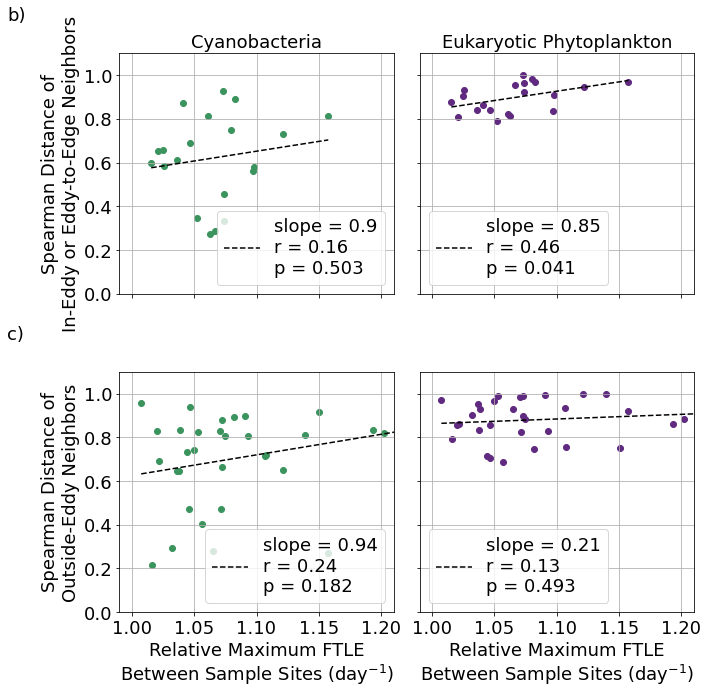

In [76]:
timescale = '28'

fig, ax = plt.subplots(2,2,figsize=(10,10))

eddy_neighbor_df = neighbor_df[(neighbor_df['Eddy Code']=='YY') | (neighbor_df['Eddy Code']=='NY') | (neighbor_df['Eddy Code']=='YN')]
not_eddy_neighbor_df = neighbor_df[(neighbor_df['Eddy Code']!='YY') & (neighbor_df['Eddy Code']!='NY') & (neighbor_df['Eddy Code']!='YN')]

dist_data = [eddy_neighbor_df['cyan_phyto_STA_spearman'],
             eddy_neighbor_df['euk_phyto_STA_spearman'],
             not_eddy_neighbor_df['cyan_phyto_STA_spearman'],
             not_eddy_neighbor_df['euk_phyto_STA_spearman']]
          
ax[0,0].set_title('Cyanobacteria')
ax[0,1].set_title('Eukaryotic Phytoplankton')

colors = [cyan_color,euk_color]
for d in range(len(dist_data)):
    if d < 2:
        a = ax[0,d]
        c = colors[d]
        x = eddy_neighbor_df['FTLE%sd_peak_bn'%(timescale)]
        a.set_xticklabels([])
        
    else: 
        a = ax[1,d-2]
        a.set_xlabel('Relative Maximum FTLE\nBetween Sample Sites (day$^{-1}$)')
        a.set_ylim([0,1.1])
        c = colors[d-2]
        x = not_eddy_neighbor_df['FTLE%sd_peak_bn'%(timescale)]
        
    a.set_ylim([0,1.1])
    a.set_xlim([0.99,1.21])
    
    y = dist_data[d]
    a.scatter(x,y,c=c)
    a.grid()
    
    # FIT REGRESSION TO DATA
    slope, intercept, r_value, p_value, std_err = spy.linregress(x,y)

    x_sorted = sorted(x)
    fit = [slope*i+intercept for i in x_sorted]
    a.plot(x_sorted,fit,label='slope = %s\nr = %s\np = %s'%(round(slope,2),round(r_value,2),round(p_value,3)),c='k',linestyle='--')
    a.legend()

ax[0,1].set_yticklabels([])    
ax[1,1].set_yticklabels([])    

ax[0,0].set_ylabel('Spearman Distance of\nIn-Eddy or Eddy-to-Edge Neighbors')
ax[1,0].set_ylabel('Spearman Distance of\nOutside-Eddy Neighbors')

ax[0,0].text(0.9,1.25,'b)')
ax[1,0].text(0.9,1.25,'c)')


plt.tight_layout()
#plt.savefig(euk_paper_dir + 'figs/supp/prelim/neighbor_spearman_vs_FTLE_max.pdf',dpi=350,bbox_inches='tight',format='pdf')